In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn.metrics 
import warnings
warnings.simplefilter('ignore')

This project is to predict the fraud credit card. Three models will be implemented:
- Logistic Regression
- Random Forest
- Gredient Boosting Tree

The whole project would be devided into five parts:
- Upload data
- Exploratory Data Analyst and Data Engeering
- Useful functions defination
- Implement models and test
- Project summary

# Upload data

In [3]:
loans = pd.read_csv("lending-club-data.csv")
print("the shape of our data is: " + str(loans.shape))
loans.head(2)

the shape of our data is: (122607, 68)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


# Exploratory data analysis and data engineering

re-code the label column as safe_loans

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x == 0 else -1)
loans = loans.drop("bad_loans", axis = 1)

In [5]:
loans.columns.get_values()

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'emp_length_num', 'grade_num', 'sub_grade_num

delete features that do not related to fraud loans; delete repeated columns

In [6]:
loans = loans.drop(["id", "member_id", "zip_code","emp_title", "earliest_cr_line","last_pymnt_d", "next_pymnt_d", 
                    "final_d", "issue_d", "url", "desc","purpose","title","initial_list_status","last_credit_pull_d",
                   "addr_state", "collection_recovery_fee","policy_code"], axis = 1)
loans = loans.drop(["loan_amnt","emp_length","grade_num", "sub_grade_num"],axis = 1)

### depart the categorical variables and numeric variables, and analyse them seperately


In [7]:
def depart_cate_number(data):
    categorical_variables = []
    numeric_variables = []
    for feat_name, feat_type in zip(data.columns, data.dtypes):
        if feat_type == "float64" or feat_type == "int64":
            numeric_variables.append(feat_name)
        else:
            categorical_variables.append(feat_name)
    return numeric_variables, categorical_variables
numeric_variables, categorical_variables = depart_cate_number(loans)
print("categorical variables are: ") 
print (categorical_variables)
print("  ")
print("numerical variables are: ")
print(numeric_variables)

categorical variables are: 
['term', 'grade', 'sub_grade', 'home_ownership', 'is_inc_v', 'loan_status', 'pymnt_plan', 'status']
  
numerical variables are: 
['funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'not_compliant', 'inactive_loans', 'emp_length_num', 'delinq_2yrs_zero', 'pub_rec_zero', 'collections_12_mths_zero', 'short_emp', 'payment_inc_ratio', 'last_delinq_none', 'last_record_none', 'last_major_derog_none', 'safe_loans']


### categorical variables

first, let's take a closer look at the categorical values and their counts

In [8]:
for feature in categorical_variables:
    unique, count = np.unique(loans[feature], return_counts=True) 
    print("-------------------")
    print("for the feature: " + str(feature))
    print(list(unique))
    print(list(count))

-------------------
for the feature: term
[' 36 months', ' 60 months']
[97801, 24806]
-------------------
for the feature: grade
['A', 'B', 'C', 'D', 'E', 'F', 'G']
[22314, 37172, 29950, 19175, 8990, 3932, 1074]
-------------------
for the feature: sub_grade
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
[2987, 3352, 3955, 5993, 6027, 5837, 7096, 9036, 8279, 6924, 7068, 6726, 5690, 5402, 5064, 4593, 4391, 3745, 3489, 2957, 2080, 2184, 1785, 1581, 1360, 1105, 930, 770, 629, 498, 370, 241, 167, 152, 144]
-------------------
for the feature: home_ownership
['MORTGAGE', 'OTHER', 'OWN', 'RENT']
[59240, 179, 9943, 53245]
-------------------
for the feature: is_inc_v
['Not Verified', 'Source Verified', 'Verified']
[45751, 30766, 46090]
-------------------
for the feature: loan_status
['Charged Off', 'Default', 'Does not meet the cr

According to the values and counts, we can see that 
- the column pymnt_plan only contain one value, so we can delete it
- also, for the column "status" and "loan_status", they are sort of the fraud situation, so we may not get access to those information in the prediction period, so we will delete them to avoid look ahead bia

In [9]:
loans = loans.drop(["pymnt_plan", "status", "loan_status"], axis = 1)

### numeric_variables

In [10]:
loans[numeric_variables].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 38 columns):
funded_amnt                    122607 non-null int64
funded_amnt_inv                122607 non-null int64
int_rate                       122607 non-null float64
installment                    122607 non-null float64
annual_inc                     122603 non-null float64
dti                            122607 non-null float64
delinq_2yrs                    122578 non-null float64
inq_last_6mths                 122578 non-null float64
mths_since_last_delinq         50500 non-null float64
mths_since_last_record         12531 non-null float64
open_acc                       122578 non-null float64
pub_rec                        122578 non-null float64
revol_bal                      122607 non-null int64
revol_util                     122607 non-null float64
total_acc                      122578 non-null float64
out_prncp                      122607 non-null float64
out_prncp_inv    

#### for missing data: any significant relationship with fraud?

In [11]:
loans.groupby("safe_loans")["safe_loans"].count()

safe_loans
-1    23150
 1    99457
Name: safe_loans, dtype: int64

In [12]:
na_mths_since_last_record = loans["mths_since_last_record"].isnull()
loans.groupby([na_mths_since_last_record,"safe_loans"])["safe_loans"].count()

mths_since_last_record  safe_loans
False                   -1             2333
                         1            10198
True                    -1            20817
                         1            89259
Name: safe_loans, dtype: int64

In [13]:
na_mths_since_last_delinq = loans["mths_since_last_delinq"].isnull()
loans.groupby([na_mths_since_last_delinq,"safe_loans"])["safe_loans"].count()

mths_since_last_delinq  safe_loans
False                   -1             9617
                         1            40883
True                    -1            13533
                         1            58574
Name: safe_loans, dtype: int64

In [14]:
na_mths_since_last_major_derog = loans["mths_since_last_major_derog"].isnull()
loans.groupby([na_mths_since_last_major_derog,"safe_loans"])["safe_loans"].count()

mths_since_last_major_derog  safe_loans
False                        -1             2881
                              1            12579
True                         -1            20269
                              1            86878
Name: safe_loans, dtype: int64

we can see that the there is no significant relationship for safe/fraud loan and missing values, so we can just delete those columns with too much missing

In [15]:
loans = loans.drop(["mths_since_last_record","mths_since_last_delinq","mths_since_last_major_derog"], axis = 1)

#### how each numeric variables correlated?

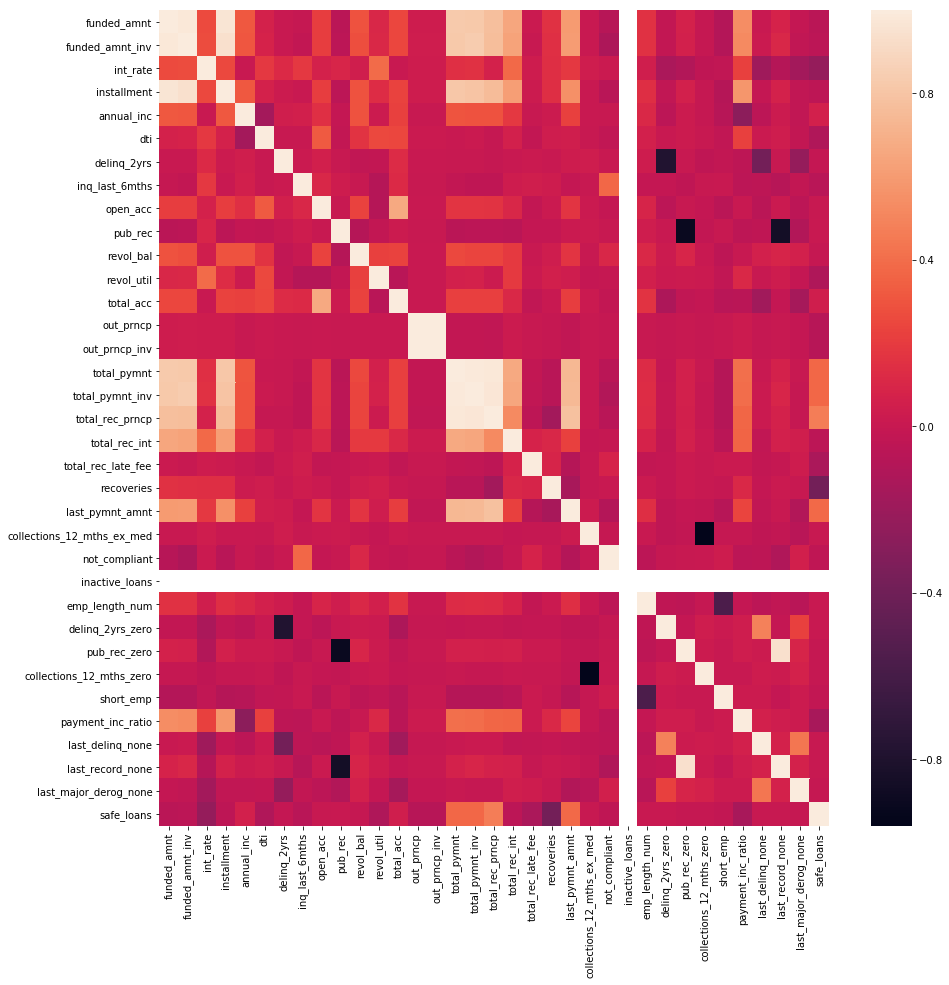

In [16]:
numeric_variables, categorical_variables = depart_cate_number(loans)
covariance = loans[numeric_variables].corr()
plt.figure(figsize = [15,15])
sns.heatmap(covariance) 

In [17]:
# what is wrong with inactive_loans, which is perfectly correlated with all other features?
loans["inactive_loans"].unique()

array([1])

According to the loan features heatmap:
- inactive_loans only contain one value and would provide no infomation, so delete it.
- also, we can also detele the columns that are perfectly correlated

In [18]:
loans = loans.drop(["inactive_loans","funded_amnt","installment","out_prncp","total_pymnt","total_pymnt_inv",
                "delinq_2yrs","pub_rec_zero","collections_12_mths_ex_med","last_record_none","short_emp"], axis = 1)

Check the new numeric variables

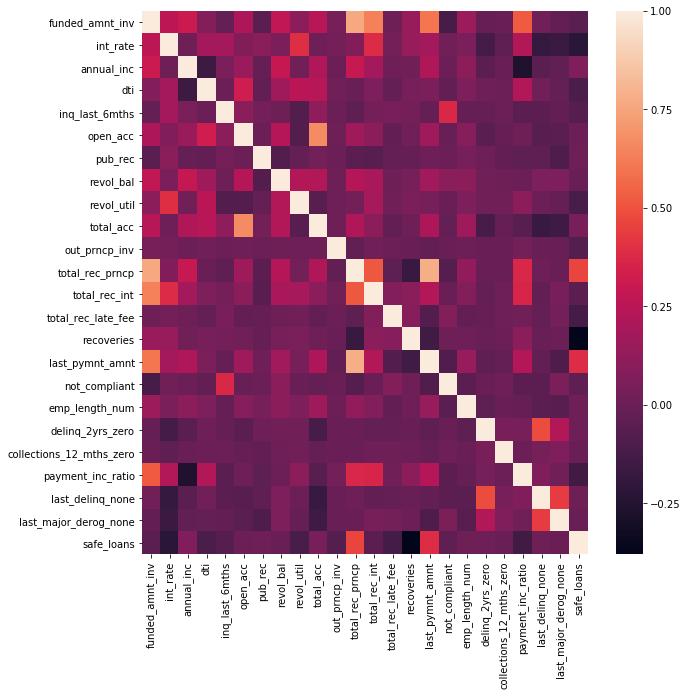

In [19]:
numeric_variables, categorical_variables = depart_cate_number(loans)
covariance = loans[numeric_variables].corr()
plt.figure(figsize = [10,10])
sns.heatmap(covariance)  

- the corrrelation matrix looks good now
- note the label column safe_loans: there is no feature that is very correlated with this column, which tells us that there is less probabiity of look ahead bia from these numberic features

In [20]:
# the final feature matrix
feature_valuse = loans.drop("safe_loans", axis = 1)
related_features_list = list(feature_valuse.columns)
print(related_features_list)
loans.head()

['funded_amnt_inv', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'is_inc_v', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'not_compliant', 'emp_length_num', 'delinq_2yrs_zero', 'collections_12_mths_zero', 'payment_inc_ratio', 'last_delinq_none', 'last_major_derog_none']


,funded_amnt_inv,term,int_rate,grade,sub_grade,home_ownership,annual_inc,is_inc_v,dti,inq_last_6mths,...,recoveries,last_pymnt_amnt,not_compliant,emp_length_num,delinq_2yrs_zero,collections_12_mths_zero,payment_inc_ratio,last_delinq_none,last_major_derog_none,safe_loans
0,4975,36 months,10.65,B,B2,RENT,24000.0,Verified,27.65,1.0,...,0.00,171.62,0,11,1.0,1.0,8.14350,1,1,1
1,2500,60 months,15.27,C,C4,RENT,30000.0,Source Verified,1.00,5.0,...,117.08,119.66,0,1,1.0,1.0,2.39320,1,1,-1
2,2400,36 months,15.96,C,C5,RENT,12252.0,Not Verified,8.72,2.0,...,0.00,649.91,0,11,1.0,1.0,8.25955,1,1,1
3,10000,36 months,13.49,C,C1,RENT,49200.0,Source Verified,20.00,1.0,...,0.00,357.48,0,11,1.0,1.0,8.27585,0,1,1
4,5000,36 months,7.90,A,A4,RENT,36000.0,Source Verified,11.20,3.0,...,0.00,161.03,0,4,1.0,1.0,5.21533,1,1,1


### missing data

In [21]:
# how many missing values ?
loans.isnull().mean(axis = 0)

funded_amnt_inv             0.000000
term                        0.000000
int_rate                    0.000000
grade                       0.000000
sub_grade                   0.000000
home_ownership              0.000000
annual_inc                  0.000033
is_inc_v                    0.000000
dti                         0.000000
inq_last_6mths              0.000237
open_acc                    0.000237
pub_rec                     0.000237
revol_bal                   0.000000
revol_util                  0.000000
total_acc                   0.000237
out_prncp_inv               0.000000
total_rec_prncp             0.000000
total_rec_int               0.000000
total_rec_late_fee          0.000000
recoveries                  0.000000
last_pymnt_amnt             0.000000
not_compliant               0.000000
emp_length_num              0.000000
delinq_2yrs_zero            0.000237
collections_12_mths_zero    0.001183
payment_inc_ratio           0.000033
last_delinq_none            0.000000
l

only serval columns contain few missing value, so I think it is fine to just drop those obervations


In [22]:
print("the data shape before dropping missing value: " + str(loans.shape))
loans = loans.dropna(axis = 0)
print("the data shape after dropping missing value:  " + str(loans.shape))

the data shape before dropping missing value: (122607, 29)
the data shape after dropping missing value:  (122462, 29)


### one-hot encoding: encode string columns into numeric or dummy variables here

In [23]:
numeric_variables, categorical_variables = depart_cate_number(loans)
print("the nember of categorical feature is:    " + str(len(categorical_variables)))
all_one_hot = pd.DataFrame(index = loans.index)
for variable in categorical_variables:
    one_hot = pd.get_dummies(loans[variable])
    all_one_hot = pd.concat([all_one_hot, one_hot], axis = 1)
all_data = loans.drop(categorical_variables, axis = 1)
all_data = pd.concat([all_data,all_one_hot], axis = 1)
print("the new added one-hot data shape is:   " + str(all_one_hot.shape))
print("the all data shape with one-hot data is:" + str(all_data.shape))

the nember of categorical feature is:    5
the new added one-hot data shape is:   (122462, 51)
the all data shape with one-hot data is:(122462, 75)


29 + 51 - 5 = 75, the number of columns make sense

In [24]:
# extract the feature name list perparing for the future uesage
all_feature_list = list(all_data.drop("safe_loans", axis = 1).columns.get_values())
print(all_feature_list)
print(len(all_feature_list))
all_data.head()

['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'not_compliant', 'emp_length_num', 'delinq_2yrs_zero', 'collections_12_mths_zero', 'payment_inc_ratio', 'last_delinq_none', 'last_major_derog_none', ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'MORTGAGE', 'OTHER', 'OWN', 'RENT', 'Not Verified', 'Source Verified', 'Verified']
74


,funded_amnt_inv,int_rate,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,G3,G4,G5,MORTGAGE,OTHER,OWN,RENT,Not Verified,Source Verified,Verified
0,4975,10.65,24000.0,27.65,1.0,3.0,0.0,13648,83.7,9.0,...,0,0,0,0,0,0,1,0,0,1
1,2500,15.27,30000.0,1.00,5.0,3.0,0.0,1687,9.4,4.0,...,0,0,0,0,0,0,1,0,1,0
2,2400,15.96,12252.0,8.72,2.0,2.0,0.0,2956,98.5,10.0,...,0,0,0,0,0,0,1,1,0,0
3,10000,13.49,49200.0,20.00,1.0,10.0,0.0,5598,21.0,37.0,...,0,0,0,0,0,0,1,0,1,0
4,5000,7.90,36000.0,11.20,3.0,9.0,0.0,7963,28.3,12.0,...,0,0,0,0,0,0,1,0,1,0


### train test split, with test size = 0.2

In [25]:
train ,test = train_test_split(all_data,test_size=0.2) 
print ("the shape of the train data is: " + str(train.shape))
print ("the shape of thetest data is:   " + str(test.shape))

the shape of the train data is: (97969, 75)
the shape of thetest data is:   (24493, 75)


### the issue of imbalanced data

the imbalanced ratio of our dataset is: 0.232438484376
the shape of our dataset is: (97969, 75)


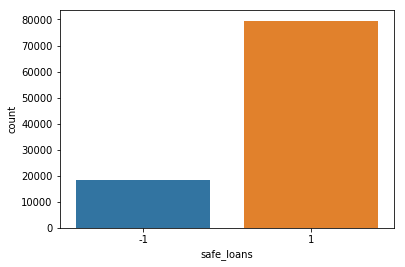

In [41]:
# take a look at the imbalanced ratio
train_imbalanced_rat = len(train[train["safe_loans"] == -1])/np.float(len(train[train["safe_loans"] == 1]))
print ("the imbalanced ratio of our dataset is: " + str(train_imbalanced_rat))
print("the shape of our dataset is: " + str(train.shape))
sns.countplot(train["safe_loans"])

use SMOTE (Synthetic Minority Over-Sampling Technique) method to deal with the imbalance in training data

the shape of the dataset after balance is: (158984, 75)


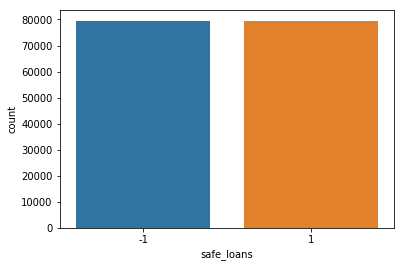

In [27]:
smote = SMOTE(random_state=0)
x_reb,y_reb=smote.fit_sample(train[all_feature_list],train["safe_loans"])
balance_train = pd.DataFrame(x_reb, columns=all_feature_list)
balance_train["safe_loans"] = y_reb
print("the shape of the dataset after balance is: " + str(balance_train.shape))
sns.countplot(balance_train["safe_loans"])

# to sum up: our train and teat data are:

In [28]:
balance_train.head(2)

,funded_amnt_inv,int_rate,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,G4,G5,MORTGAGE,OTHER,OWN,RENT,Not Verified,Source Verified,Verified,safe_loans
0,6000.0,12.42,37500.0,24.99,1.0,9.0,0.0,9053.0,51.5,17.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,4000.0,14.96,50000.0,7.80,0.0,4.0,0.0,4550.0,22.3,15.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1


In [29]:
test.head(2)

,funded_amnt_inv,int_rate,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,G3,G4,G5,MORTGAGE,OTHER,OWN,RENT,Not Verified,Source Verified,Verified
14802,10000,13.06,204000.0,19.28,0.0,17.0,0.0,43128,67.8,26.0,...,0,0,0,1,0,0,0,0,0,1
10564,34975,15.23,94000.0,13.49,1.0,8.0,0.0,37120,70.2,20.0,...,0,0,0,1,0,0,0,0,1,0


In [30]:
print all_feature_list

['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'not_compliant', 'emp_length_num', 'delinq_2yrs_zero', 'collections_12_mths_zero', 'payment_inc_ratio', 'last_delinq_none', 'last_major_derog_none', ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'MORTGAGE', 'OTHER', 'OWN', 'RENT', 'Not Verified', 'Source Verified', 'Verified']


# useful functions

In [31]:
# the function to draw a AUC curve
def auc_curve(model):
    probs = model.predict_proba(test[all_feature_list])[:,1]
    fpr, tpr, threshold = sklearn.metrics.roc_curve(np.array(test["safe_loans"]), probs)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('ROC curve')
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [32]:
def confusion_matrix_func(true, prediction):
    data = sklearn.metrics.confusion_matrix(true,prediction)
    confusion_matrix = pd.DataFrame(data, index = ["true = -1","true = 1"], 
                                    columns = ["predicted = -1", "predicted = 1"])
    precision = confusion_matrix.iloc[1,1] / np.float(confusion_matrix["predicted = 1"].sum())
    recall = confusion_matrix.iloc[1,1] / np.float(confusion_matrix.loc["true = 1"].sum())
    return confusion_matrix, precision, recall

# Implement different models

## Base line model

Without implement any prediction model, we would guess the loan with its majority class, which is a "safe loan"

In [43]:
1 - len(all_data[all_data["safe_loans"] == -1])/np.float(len(all_data[all_data["safe_loans"] == 1]))

0.7672438091403262

The accuracy of this majority guess is 76.72%, that is to say, our model accuracy should be at least better that 76.72%, or it is meaningless 

## model 1: logistic model

#### choosing the best tuning parameter

In [ ]:
parameters = {'C': np.linspace(1, 20, 10)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=1, n_jobs=3, scoring='roc_auc')
clf.fit(train[all_feature_list], balance_train["safe_loans"])

In [ ]:
clf.best_params_

In [33]:
classifier = LogisticRegression(C = 9.44) 
classifier.fit(balance_train[all_feature_list], balance_train["safe_loans"]) 
train_error = 1- (classifier.score(balance_train[all_feature_list],balance_train["safe_loans"]))
print train_error
test_error = 1 - (classifier.score(test[all_feature_list],test["safe_loans"]))
print test_error

0.0062396215971418645
0.0043685951088066055


In [34]:
true = test["safe_loans"]
prediction = classifier.predict(test[all_feature_list])
confusion_matrix, precision, recall = confusion_matrix_func(true, prediction)
confusion_matrix, precision, recall

(           predicted = -1  predicted = 1
 true = -1            4551             94
 true = 1               13          19835,
 0.9952832555572282,
 0.9993450221684804)

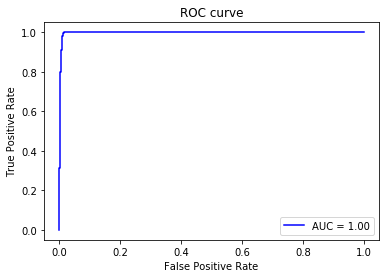

In [35]:
auc_curve(classifier)

# model 2: random forest

#### choosing the best tuning parameter

In [ ]:
estimator = RandomForestClassifier(random_state=0)
rf_tuned_parameters = {'n_estimators': [500,600,700], 
                       "max_depth": [30,50,70],
                       'min_samples_leaf': [3,5,7,9]}
cv_grid = GridSearchCV(estimator, param_grid = rf_tuned_parameters, scoring = 'roc_auc', verbose = 5, n_jobs = 70)
cv_grid.fit(balance_train[all_feature_list], balance_train["safe_loans"])
best_parameters = cv_grid.best_params_

In [ ]:
best_parameters

In [36]:
rf_model = RandomForestClassifier(max_depth = 30, min_samples_leaf = 3,n_estimators = 700)
rf_model.fit(balance_train[all_feature_list], balance_train["safe_loans"])
true = test["safe_loans"]
prediction = rf_model.predict(test[all_feature_list])
confusion_matrix, precision, recall = confusion_matrix_func(true, prediction)
confusion_matrix, precision, recall

(           predicted = -1  predicted = 1
 true = -1            4463            182
 true = 1                6          19842,
 0.9909109069117059,
 0.9996977025392987)

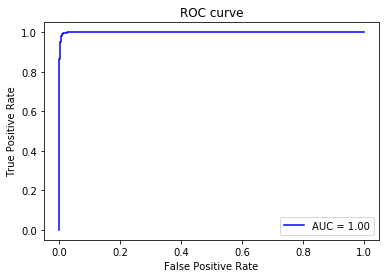

In [37]:
auc_curve(rf_model)

# model 3: boosting

#### choosing the best tuning parameter

In [ ]:
estimator = GradientBoostingClassifier(random_state=0)
GBM_tuned_parameters = {'n_estimators': [100,200,300], 
                       "learning_rate": [0.15, 0.1, 0.05],
                       "max_depth": [30,50,70],
                       'min_samples_leaf': [3,5,7,9]}
cv_grid = GridSearchCV(estimator, param_grid = GBM_tuned_parameters, scoring = 'roc_auc', verbose = 5, n_jobs = 70)
cv_grid.fit(balance_train[all_feature_list], balance_train["safe_loans"])
best_parameters = cv_grid.best_params_
best_parameters

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.


In [39]:
gbm_model = GradientBoostingClassifier(max_depth = 30, min_samples_leaf = 7, n_estimators = 300, learning_rate = 0.15)
gbm_model.fit(balance_train[all_feature_list], balance_train["safe_loans"])
true = test["safe_loans"]
prediction = gbm_model.predict(test[all_feature_list])
confusion_matrix, precision, recall = confusion_matrix_func(true, prediction)
confusion_matrix, precision, recall

(           predicted = -1  predicted = 1
 true = -1            4610             35
 true = 1                1          19847,
 0.9982396137209536,
 0.9999496170898831)

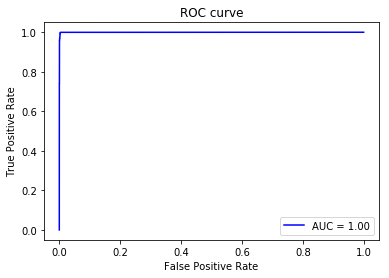

In [40]:
auc_curve(gbm_model)

## sum up

this project use three model to detect fraud credit card, including logistic regression, random forest and GBM, it turns out that all of the three models perform so great with 99.9% accuracy and 1 AUC.